### Implementing non ML baseline for playlist generation 


Notebook that implements and analyzes the performance of a naive, non ML music reccomenders. 
The model continues playlists by always reccomending the most popular songs on spotify. The popularity
is computed from the frequency of songs in the other only 9% of the training dataset. If a popular song is already
in the playlist, then we skip it. 

Validation set is constructed to be the first 10,000 playlists of the training dataset (1%). Each playlist is cut in half
and we predict the same number of songs as there are held out

Analysis shows that the performance of this model is (not a shocker) very bad; on average only correctly predicting 1% of songs in each heldout playlist

NOTE: This precision score could be biased by the fact that some playlists are shorter then others. If some playlists are very short and we 
predicted a few sounds correctly, the R score would be higher because there are less heldout songs to start with. When considering all songs over all
playlists, the number is slighlty higher



In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import json
from collections import defaultdict
from util import parse_playlist_dataset

In [ ]:
# subsets of dataset we are using
VAL_START = 0
VAL_END = 10
TRAIN_START = 10
TRAIN_END = 50

In [2]:
"""
for each list of songs, split the list into two equal halfs. First half is shown to the model second half is for hold out
Validation dataset contains the first 10,000 playlists
"""
def create_validation_data(val_start, val_end):
    df_playlist_song_val, _, _ = parse_playlist_dataset(start_range=val_start, end_range=val_end)
    playlist_to_tracks_val = df_playlist_song_val.groupby("pid")["track_uri"].apply(list).to_dict()
    for pid in playlist_to_tracks_val.keys():
        track_list = playlist_to_tracks_val[pid]
        seen_songs = track_list[:len(track_list)//2]
        holdout_songs = track_list[len(track_list)//2:]
        playlist_to_tracks_val[pid] = {"seen":seen_songs, "heldout":holdout_songs}
    return playlist_to_tracks_val

In [3]:
def construct_most_popular_train(train_start, train_end):
    # construct most popular lookup table from training data
    df_playlist_song_train, _, _ = parse_playlist_dataset(start_range=train_start, end_range=train_end)
    
    # this is our first "model"
    song_counter_train = defaultdict(int)
    for track_uri in df_playlist_song_train["track_uri"]:
        song_counter_train[track_uri] += 1
    return song_counter_train

In [4]:
def construct_id_to_songname(lower_bound, upper_bound):
    # lookup from track_id to name for all songs
    _, df_tracks_train_all,_ = parse_playlist_dataset(start_range=lower_bound, end_range=upper_bound)
    uri_to_songname = defaultdict(int)
    for uri, name in zip(df_tracks_train_all["track_uri"], df_tracks_train_all["track_name"]):
        uri_to_songname[uri] = name
    print(f"total number of unique songs in the dataset: {len(uri_to_songname)}")
    return uri_to_songname

In [5]:
"""
Given a "model", an unseen playlist of songs and held out songs, predict the held out songs
"""
def continue_playlist_v0(most_popular_songs: dict[str,int], new_playlist: list[str], k: int):
    predictions = []
    new_playlist_set = set(new_playlist)
    sorted_songs = sorted(most_popular_songs.keys(), key=lambda x: most_popular_songs[x], reverse=True)

    for song in sorted_songs:
        if song not in new_playlist_set:         # if this song is not already in the playlist, add it
            predictions.append(song)
        if len(predictions) == k: break
    return predictions

"""
Compute % of relevant tracks predicted 

NOTE: This metric can also be computed on an artist level, where a correct prediction is any song from the same artist. 
"""
def R_precision(predicted_songs: set[str], heldout_songs:set[str]) -> float:
    assert(len(predicted_songs) == len(heldout_songs))
    num_matches = len(predicted_songs.intersection(heldout_songs))
    return (num_matches/len(heldout_songs),num_matches)


"""
Discounted Cumulative Gain weights the relavance of a correctly predicted song by where it came in your prediction list.

You want your "best predictions" at the top of the list.

The normalization constant considers the case where all of the correct predictions were at the top of the list

NOTE: I dont want to use this metric with a binary relevance score because it does not take into account the case where all but one of the predictions
are not in the heldoutset but the first prediction is -> this gets a perfect score
"""
def nDCG(predicted_songs: list[str], heldout_songs:set[str]) -> float:
    # Create binary relevance list
    relevance = [1 if song in heldout_songs else 0 for song in predicted_songs]
    # debug = True if sum(relevance)> 0 else False
    
    # Calculate DCG
    dcg = 0
    for i, rel in enumerate(relevance):
        dcg += rel / math.log2(i + 2)
    
    # Calculate IDCG (ideal DCG)
    # Sort relevance values in descending order (1s then 0s)
    ideal_relevance = sorted(relevance, reverse=True)
    idcg = 0
    for i, rel in enumerate(ideal_relevance):
        idcg += rel / math.log2(i + 2)
    
    # Handle edge case where there are no relevant items
    if idcg == 0:
        return 0.0

    # if(debug):
    #     print(relevance)
    #     print(ideal_relevance)
    #     print(dcg)
    #     print(idcg)
    #     print(dcg / idcg)
    #     print("\n")
        
    return dcg / idcg


"""
Model performance metric that measures how many batches of 10 songs does a user need to cycle over
before it gets a relevant song?

51 indicates that no relevant soung was found
"""
def clickthru_rate(most_popular_songs, seen_songs: set[str], heldout_songs:set[str]):
    num_clicks = 0
    sorted_songs = sorted(most_popular_songs.keys(), key=lambda x: most_popular_songs[x], reverse=True)
    song_idx = 0
    while num_clicks < 51:
        # generate a list of 10 predictions
        num_clicks += 1
        predictions = set()
        while(len(predictions) < 10):
            curr_song = sorted_songs[song_idx]
            song_idx += 1
            if curr_song in seen_songs: 
                continue
            predictions.add(curr_song)
        
        # check if any of these songs are in the heldout set, we are done
        if(len(predictions.intersection(heldout_songs)) > 0):
            break
    return num_clicks

In [6]:

def plot_percentage_distribution(scores):
    """
    Create a histogram showing the distribution of percentage scores.
    
    Args:
        scores: A list or array of percentage values (0-100)
    """
    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Set bin edges from 0 to 100 with steps of 5
    bins = np.arange(0, 105, 5)  # 0, 5, 10, ..., 100
    
    # Create the histogram
    n, bins, patches = ax.hist(scores, bins=bins, alpha=0.7, 
                              color='skyblue', edgecolor='black')
    
    # Add a grid for easier reading
    ax.grid(axis='y', alpha=0.75, linestyle='--')
    
    # Add titles and labels
    ax.set_title('Distribution of R-Precision for Each Playlist', fontsize=15)
    ax.set_xlabel('Percentage Score', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    
    
    # Add some statistics as text
    stats_text = (f"Mean: {np.mean(scores):.1f}%\n"
                  f"Median: {np.median(scores):.1f}%\n"
                  f"Std Dev: {np.std(scores):.1f}%\n"
                  f"Min: {min(scores):.1f}%\n"
                  f"Max: {max(scores):.1f}%")
    
    ax.text(0.95, 0.95, stats_text, transform=ax.transAxes,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

def plot_nDCG_distribution(nDCG):
    """
    Create a histogram showing the distribution of percentage scores.
    
    Args:
        scores: A list or array of percentage values (0-100)
    """
    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Set bin edges from 0 to 100 with steps of 5
    bins = np.arange(0, 105, 5)  # 0, 5, 10, ..., 100
    
    # Create the histogram
    n, bins, patches = ax.hist(nDCG, bins=bins, alpha=0.7, 
                              color='skyblue', edgecolor='black')
    
    # Add a grid for easier reading
    ax.grid(axis='y', alpha=0.75, linestyle='--')
    
    # Add titles and labels
    ax.set_title('Distribution of nDCG for Each Playlist', fontsize=15)
    ax.set_xlabel('Percentage Score', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    
    
    # Add some statistics as text
    stats_text = (f"Mean: {np.mean(nDCG):.1f}%\n"
                  f"Median: {np.median(nDCG):.1f}%\n"
                  f"Std Dev: {np.std(nDCG):.1f}%\n"
                  f"Min: {min(nDCG):.1f}%\n"
                  f"Max: {max(nDCG):.1f}%")
    
    ax.text(0.95, 0.95, stats_text, transform=ax.transAxes,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()


def plot_clicks_needed_distribution(clicks):
    """
    Create a histogram showing the distribution of percentage scores.
    
    Args:
        scores: A list or array of percentage values (0-100)
    """
    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Set bin edges from 0 to 100 with steps of 5
    bins = np.arange(1, 52, 1)  # 0, 5, 10, ..., 100
    
    # Create the histogram
    n, bins, patches = ax.hist(clicks, bins=bins, alpha=0.7, 
                              color='skyblue', edgecolor='black')
    
    # Add a grid for easier reading
    ax.grid(axis='y', alpha=0.75, linestyle='--')
    
    # Add titles and labels
    ax.set_title('Distribution of clicks needed for Each Playlist', fontsize=15)
    ax.set_xlabel('Percentage Score', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    
    
    # Add some statistics as text
    stats_text = (f"Mean: {np.mean(clicks):.1f}\n"
                  f"Median: {np.median(clicks):.1f}\n"
                  f"Std Dev: {np.std(clicks):.1f}\n"
                  f"Min: {min(clicks):.1f}\n"
                  f"Max: {max(clicks):.1f}")
    
    ax.text(0.95, 0.95, stats_text, transform=ax.transAxes,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()    

def plot_artist_frequencies(artist_freq_dict, topk=20):
    plt.figure(figsize=(10, 5))
    plt.bar(list(artist_freq_dict.keys())[:topk], list(artist_freq_dict.values())[:topk])
    plt.xticks(rotation=90)
    plt.xlabel('Top 20 Artist')
    plt.ylabel('Prediction Frequency')
    plt.tight_layout()
    return plt

In [7]:
# loop over the created validation dataset and pass in both splits into the model for predictions
def main():

    playlist_to_tracks_val = create_validation_data()
    song_counter_train = construct_most_popular_train()
    uri_to_songname = construct_id_to_songname()

    r_prec_per_playlist = []
    num_clicks_until_relevant = []
    nDCGs = []

    total_matches = 0
    total = 0
    song_name_preds = defaultdict(int)

    only_one = False


    # loop over validation set and compute metrics of interest for naive models
    for pid in playlist_to_tracks_val.keys():
        seen_songs = playlist_to_tracks_val[pid]['seen']
        heldout_songs = set(playlist_to_tracks_val[pid]['heldout']) # sometimes there are dups and I dont know why?
        total += len(heldout_songs)

        clicks_needed = clickthru_rate(song_counter_train, seen_songs, heldout_songs)
        num_clicks_until_relevant.append(clicks_needed)
        
        preds = continue_playlist_v0(song_counter_train, seen_songs, len(heldout_songs))
        r_prec, num_matches = R_precision(set(preds), heldout_songs)
        if(r_prec == 0 and not only_one):
            print("Once of the worst examples \n")
            only_one = True
            print(f"Songs we saw in the playlist: {list(map(lambda x: uri_to_songname[x], seen_songs))}")
            print(f"Songs we predicted: {sorted(list(map(lambda x: uri_to_songname[x], preds)))}")
            print(f"Ground truth songs{sorted(list(map(lambda x: uri_to_songname[x], heldout_songs)))}")
            print("\n")
        if(r_prec >= 0.3): # print out the best playlist we predicted
            print(f"r_prec {r_prec} \n")
            print(f"Songs we saw in the playlist: {list(map(lambda x: uri_to_songname[x], seen_songs))}")
            print(f"Songs we predicted: {sorted(list(map(lambda x: uri_to_songname[x], preds)))}")
            print(f"Ground truth songs{sorted(list(map(lambda x: uri_to_songname[x], heldout_songs)))}")
            print("\n")

        normalized_cum_gain = nDCG(preds, heldout_songs)
        nDCGs.append(normalized_cum_gain)
        
        total_matches += num_matches
        r_prec_per_playlist.append(r_prec)

        # look at predictions of model
        for pred in preds:
            song_name_preds[uri_to_songname[pred]] += 1
    
    scores_np = np.array(r_prec_per_playlist) * 100
    print(f"Total Percentage of correctly predicted songs across all playlists: {100 * total_matches/total}")
    plot_percentage_distribution(scores_np)
    plot_artist_frequencies(song_name_preds)
    # plot_nDCG_distribution(nDCGs)
    plot_clicks_needed_distribution(num_clicks_until_relevant)


Number of files being extracted: 10
['spotify_train_set/data/mpd.slice.0-999.json', 'spotify_train_set/data/mpd.slice.1000-1999.json', 'spotify_train_set/data/mpd.slice.10000-10999.json', 'spotify_train_set/data/mpd.slice.100000-100999.json', 'spotify_train_set/data/mpd.slice.101000-101999.json', 'spotify_train_set/data/mpd.slice.102000-102999.json', 'spotify_train_set/data/mpd.slice.103000-103999.json', 'spotify_train_set/data/mpd.slice.104000-104999.json', 'spotify_train_set/data/mpd.slice.105000-105999.json', 'spotify_train_set/data/mpd.slice.106000-106999.json']
Number of files being extracted: 40
['spotify_train_set/data/mpd.slice.107000-107999.json', 'spotify_train_set/data/mpd.slice.108000-108999.json', 'spotify_train_set/data/mpd.slice.109000-109999.json', 'spotify_train_set/data/mpd.slice.11000-11999.json', 'spotify_train_set/data/mpd.slice.110000-110999.json', 'spotify_train_set/data/mpd.slice.111000-111999.json', 'spotify_train_set/data/mpd.slice.112000-112999.json', 'spotif

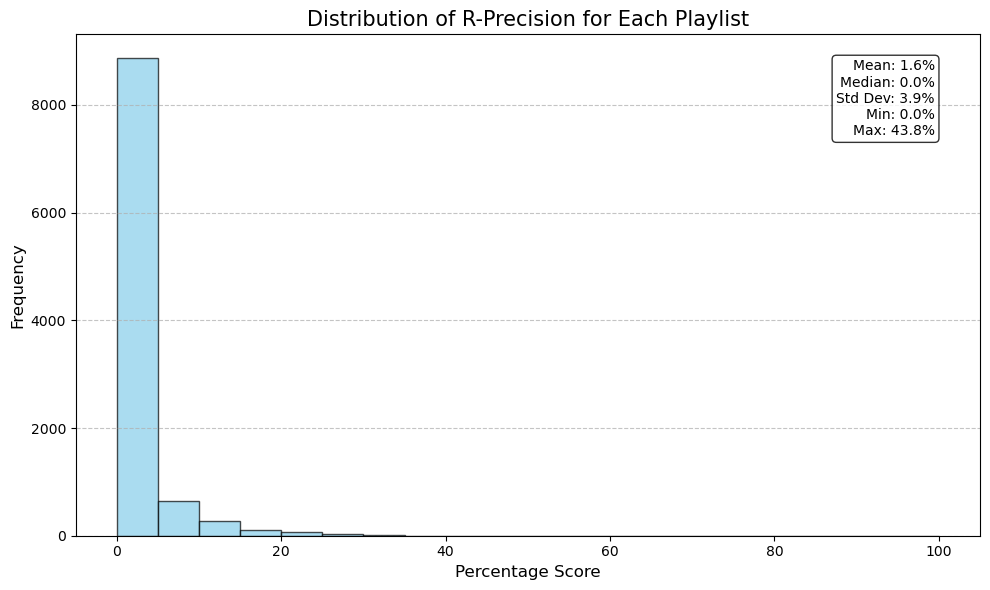

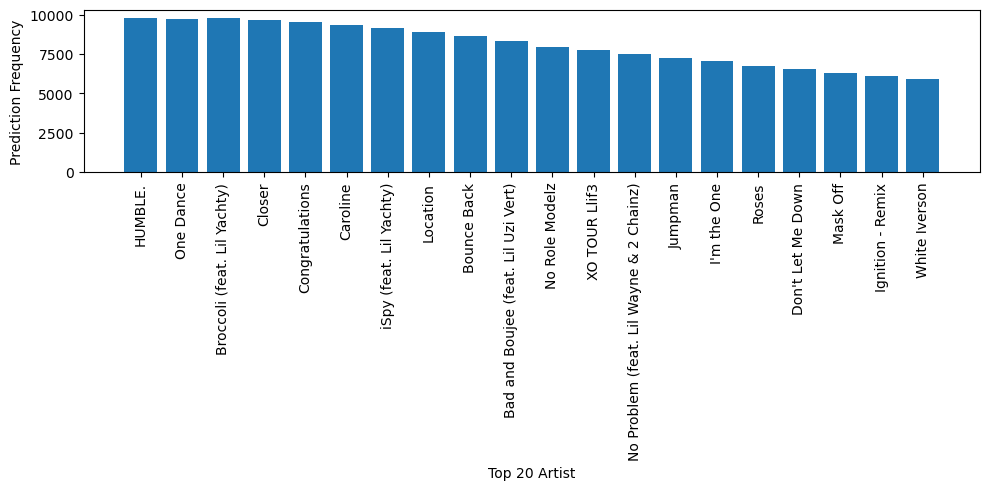

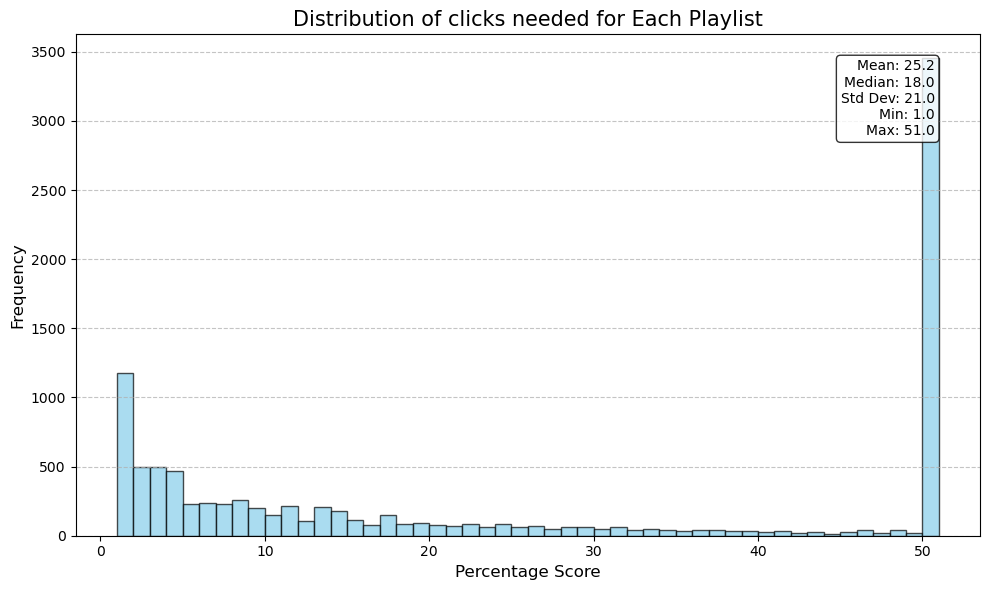

In [8]:
main()